## Import Libraries

In [2]:
# https://github.com/ACallglad/Digital_Audio_Watermarking-/blob/main/DSP_Audio_watermarking.ipynb

import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read, write
from IPython.display import Audio
from numpy.fft import fft, ifft, fftfreq, fftshift, rfft, irfft, ifftshift
import cmath
import binascii
%matplotlib inline

## Read Audio Input

You can use scipy.io.wavefile to read and write a wav file. 
Usually audio file contains two channels (left and right). We will only keep one channel for simplicity. In the code below, "data = data[:,0]" will keep channel 0.

In [3]:
Fs, data = read('guitar16kHz.wav') # the audio should be a single-channel 16kHz wav

data = data#[:,0] # keep only one channel of audio instead of both

print("Sampling Frequency is", Fs)
# number of samples
N = data.size 
print("Number of sample is",N)

Sampling Frequency is 16000
Number of sample is 168000


## Play Audio

You can use IPython.display.Audio to play audio.

In [4]:
Audio(data, rate=Fs)

## Plot the wave

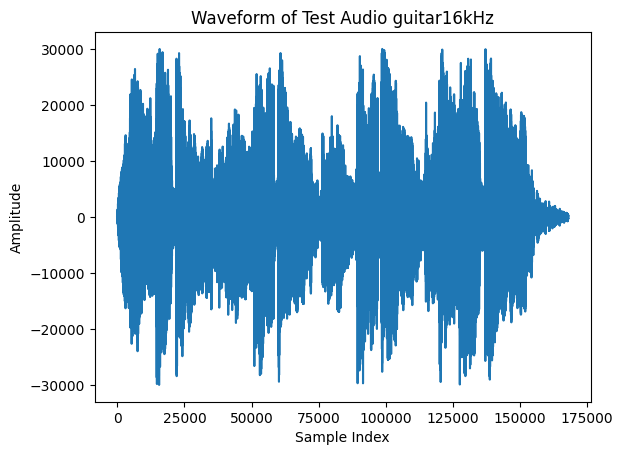

In [5]:
plt.figure()
plt.plot(data)
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.title('Waveform of Test Audio guitar16kHz')
plt.savefig('guitar16kHzform.png')
plt.show()

## Taking FFT and Converting ASCII to Binary

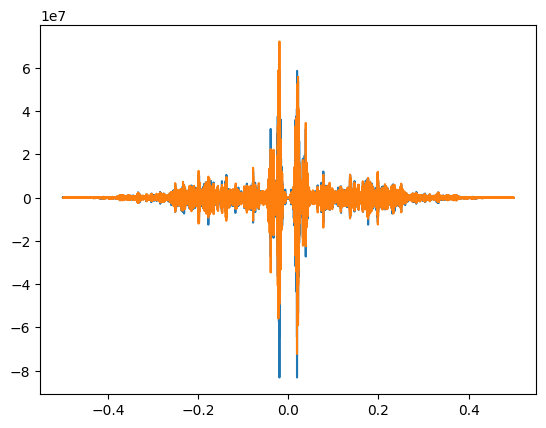

In [6]:
plt.plot(fftfreq(data.size), fft(data).real, fftfreq(data.size), fft(data).imag)

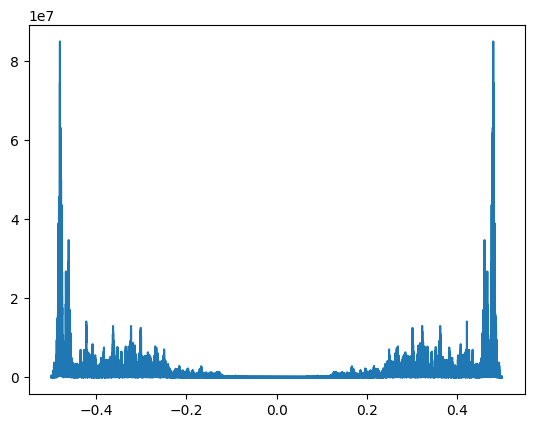

In [7]:
data_ft = fftshift(fft(data, N)) #take real only fft and shift DC level to centre
data_ft_freq = fftfreq(data.size)
plt.plot(data_ft_freq, abs(data_ft))

In [8]:
text_to_embed = "Hello this is my example-wm"

a = bin(int.from_bytes(text_to_embed.encode(), 'big'))
binary_array_to_embed = a[2:]
print(binary_array_to_embed)

10010000110010101101100011011000110111100100000011101000110100001101001011100110010000001101001011100110010000001101101011110010010000001100101011110000110000101101101011100000110110001100101001011010111011101101101


## Starting embedding

In [9]:
frame = len(binary_array_to_embed) # total length of bits to embed
embed_sample_sz = 10 # number of samples used to embed each bit
p = frame*embed_sample_sz # total number of samples used for embedding data
centre = N/2+1 #centre frequency/ zero point

embedding_freq = 5000 # in hz

X_abs = abs(data_ft) # positive values of fft
X_angle = np.angle(data_ft)# angle of each point in fft

Y = X_abs
X_embed = X_abs[int(centre-embedding_freq-p):int(centre-embedding_freq)]

a = 0.1 # amplification factor of embedding

x_mat = X_embed.reshape(frame, embed_sample_sz) # split by 
x_mat.shape

(215, 10)

### Embedding Algorithm Loop

In [10]:
for k in range(frame):
    avg = 0
    
    for l in range(embed_sample_sz): # take average of 10 samples
        avg = avg+x_mat[k][l]
    avg = avg/embed_sample_sz
    
    if binary_array_to_embed[k] == '0': # bit to encode is '0'
        print('0', end = ' ')
        for l in range(embed_sample_sz):
            x_mat[k][l] = avg # set all 10 samples to same avg value - indicates 0

    else: # when bit is '1'
        print('1', end=' ')
        for l in range(int(embed_sample_sz/2)): # from 0 to 4
            x_mat[k][l] = a*avg # set first half to 0.1*avg
        for l in range(int(embed_sample_sz/2), embed_sample_sz): # 5 to 10
            x_mat[k][l] = (2-a)*avg # 2nd half to 1.9*avg

1 0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 1 1 0 1 1 0 0 0 1 1 0 1 1 0 0 0 1 1 0 1 1 1 1 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 1 0 1 0 0 0 0 1 1 0 1 0 0 1 0 1 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 1 0 1 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 1 0 1 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 1 1 0 0 0 0 1 0 1 1 0 1 1 0 1 0 1 1 1 0 0 0 0 0 1 1 0 1 1 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 1 0 1 0 1 1 1 0 1 1 1 0 1 1 0 1 1 0 1 

### Add embeddings to full fft data

In [11]:
x_vec = x_mat.reshape(p) # bring it back to vector/array

# define range for adding embeddings back to final fft vec with embeddings
range_embed_1 = range(int(centre-embedding_freq-p), int(centre-embedding_freq))
range_embed_2 = range(int(centre+embedding_freq+1), int(centre+embedding_freq+p+1))

Y[range_embed_1] = x_vec
Y[range_embed_2] = x_vec[::-1] # reversed x_vec for symmetry

In [12]:
Y1 = np.multiply(Y, np.exp(1j*X_angle)) # embedded signal with phase information

### Magnitude response after embedding

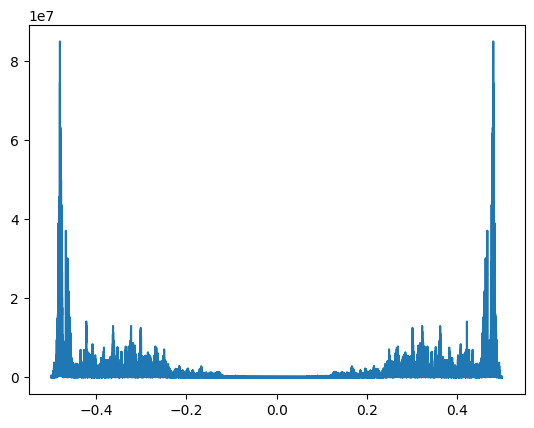

In [13]:
plt.plot(data_ft_freq, abs(Y1))

In [14]:
embedded_signal = ifft(ifftshift(Y1))
embedded_signal

array([ -96.88608338  -95.20369497j, -187.9857324  +274.94486415j,
       -278.21461559 +636.19310314j, ...,  407.48366524-1059.1322075j ,
        414.45523336 -780.87801766j,  306.56173726 -453.69314575j])

In [15]:
Audio(embedded_signal.real, rate=Fs)

## Write Audio File

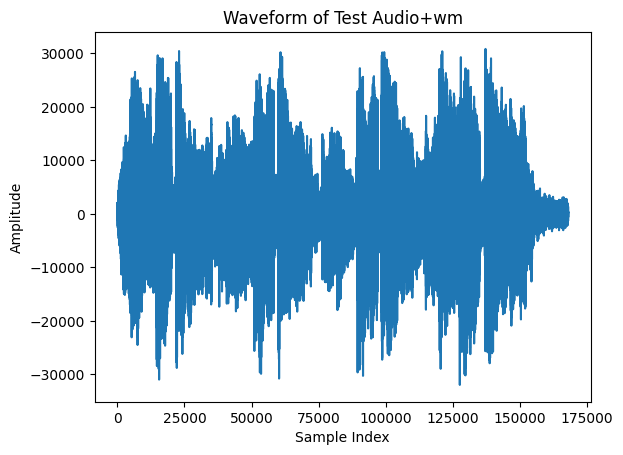

In [17]:
plt.figure()
plt.plot(embedded_signal.real)
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.title('Waveform of Test Audio+wm')
# plt.savefig('guitar-outputform.png')
plt.show()

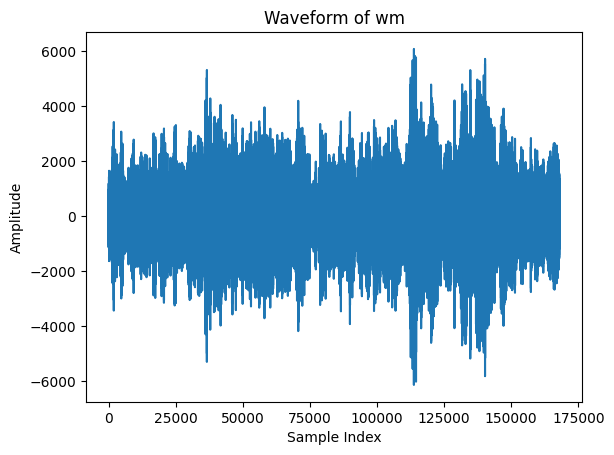

In [18]:
plt.figure()
plt.plot(embedded_signal.real - data)
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.title('Waveform of wm')
# plt.savefig('wmform.png')
plt.show()

In [19]:
Audio(embedded_signal.real - data, rate=Fs)

In [20]:
import torch, torchaudio, librosa

def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")

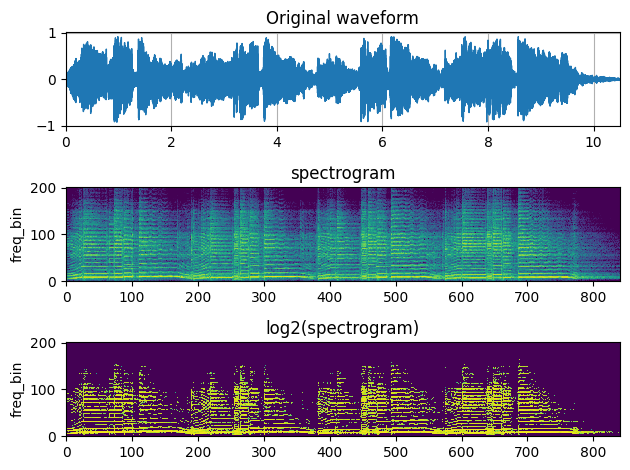

In [21]:
waveform, sample_rate = torchaudio.load("guitar16kHz.wav", normalize=True)
transform = torchaudio.transforms.Spectrogram()
spectrogram = transform(waveform)   

fig, axs = plt.subplots(3, 1)
plot_waveform(waveform, sample_rate, title="Original waveform", ax=axs[0])
plot_spectrogram(spectrogram[0], title="spectrogram", ax=axs[1])
plot_spectrogram(spectrogram[0].log2().numpy(), title="log2(spectrogram)", ax=axs[2])
fig.tight_layout()
plt.savefig('guitar16kHzspectr.png')

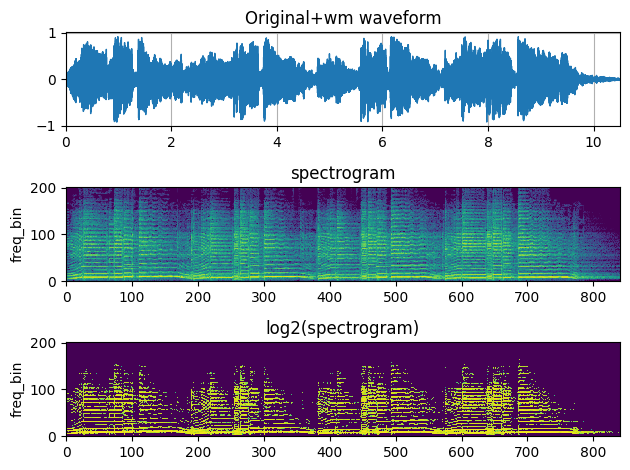

In [22]:
waveform, sample_rate = torchaudio.load("guitar16kHz-wm.wav")
transform = torchaudio.transforms.Spectrogram()
spectrogram = transform(waveform)   

fig, axs = plt.subplots(3, 1)
plot_waveform(waveform, sample_rate, title="Original+wm waveform", ax=axs[0])
plot_spectrogram(spectrogram[0], title="spectrogram", ax=axs[1])
plot_spectrogram(spectrogram[0].log2().numpy(), title="log2(spectrogram)", ax=axs[2])
fig.tight_layout()
plt.savefig('guitar16kHz-wmputspectr.png')

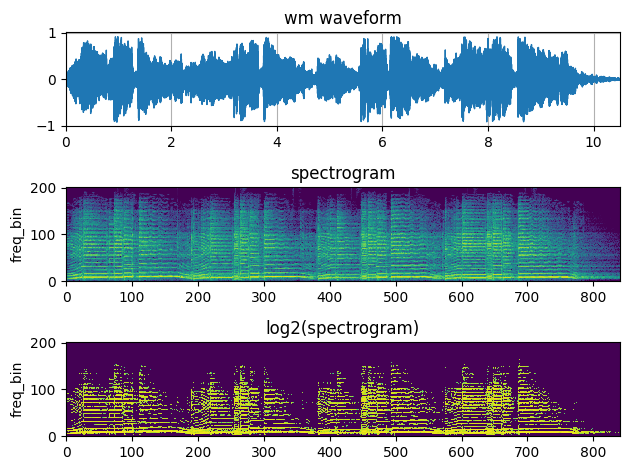

In [23]:
waveform, sample_rate = torchaudio.load("guitar-with-wm-0000100010101101.wav")
transform = torchaudio.transforms.Spectrogram()
spectrogram = transform(waveform)   

fig, axs = plt.subplots(3, 1)
plot_waveform(waveform, sample_rate, title="wm waveform", ax=axs[0])
plot_spectrogram(spectrogram[0], title="spectrogram", ax=axs[1])
plot_spectrogram(spectrogram[0].log2().numpy(), title="log2(spectrogram)", ax=axs[2])
fig.tight_layout()
plt.savefig('guitar-with-wm-0000100010101101spectr.png')

In [52]:
# write('output.wav', int(Fs), abs(embedded_signal))

# Recover Encoded Signal

In [24]:
Fs, new_data = read('guitar-output.wav')
print("Sampling Frequency is", Fs)
# number of samples
N = data.size 

Sampling Frequency is 16000


In [25]:
Y2 = fftshift(fft(new_data))
required_old_variables = [p, frame, embed_sample_sz, a, embedding_freq] # values that are required to find embedding

In [26]:
Y2_abs = abs(Y2) 
detect_window = Y2_abs[int(centre-embedding_freq-p):int(centre-embedding_freq)] # find in correct frequency window
detect_window_mat = detect_window.reshape(frame, embed_sample_sz) # reshape
recovered_binary = '' # binary string

In [27]:
for k in range(frame):
    avg = 0
    b = 0
    c = 0
    
    for l in range(embed_sample_sz): # find average
        avg = avg+detect_window_mat[k][l]
    avg = avg/embed_sample_sz
    
    # checking first half of frame
    for l in range(int(embed_sample_sz/2)):
        if(detect_window_mat[k][l] >= (1+a)*avg/2): # decision for '0' 
            c = c + 1
        else:
            b = b + 1
    
    # checking second half of the frame
    for l in range(int(embed_sample_sz/2), embed_sample_sz-1):
        if(detect_window_mat[k][l] < (3-a)*avg/2):
            c = c + 1
        else:
            b = b + 1
    
    # final bit decision
    if(b>c):
        recovered_binary = recovered_binary+'1'
    else:
        recovered_binary = recovered_binary+'0'

In [28]:
print(recovered_binary)

10010000110010101101100011011000110111100100000011101000110100001101001011100110010000001101001011100110010000001101101011110010010000001100101011110000110000101101101011100000110110001100101001011010111011101101101


In [29]:
binary_int = int(recovered_binary+str(1), 2)
binascii.unhexlify('%x' % binary_int)

b'\x90\xca\xd8\xd8\xde@\xe8\xd0\xd2\xe6@\xd2\xe6@\xda\xf2@\xca\xf0\xc2\xda\xe0\xd8\xcaZ\xee\xdb'

In [93]:
#whos

In [30]:
%whos str

Variable                Type    Data/Info
-----------------------------------------
binary_array_to_embed   str     1001000011001010110110001<...>1001011010111011101101101
recovered_binary        str     1001000011001010110110001<...>1001011010111011101101101
text_to_embed           str     Hello this is my example-wm


In [31]:
print(binary_array_to_embed == recovered_binary)

True


In [34]:
wm = bytes.fromhex(hex(int(recovered_binary, base=2))[2:]).decode('utf-8', errors='replace')
print(wm)

Hello this is my example-wm
